In [4]:
#! pip install git+https://github.com/monolok/bertinizer.git --upgrade

In [61]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
#from bertinizer import plot_data, analyze_correlation, find_outliers

In [170]:
df = pd.read_csv('/Users/antoinebertin/Documents/jedha/full_stack/projects_full_stack/north_face/sample-data.csv')
df.head()

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

# preprocessings corpus: stop words, lemmatize and clean text with regex

In [137]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [171]:
df['clean_description'] = df['description'].apply(lambda x: re.sub('[!\"#$%&()*+,-./:;<=>?@\[\]^_`{|}~\\\]+'," ", x))
df['clean_description'] = df['clean_description'].apply(lambda x: re.sub('\d+'," ", x))
df['clean_description'] = df['clean_description'].fillna('').apply(lambda x: x.lower())


In [172]:
## Tokenize the cleaned document
df['token_description']= df['clean_description'].fillna('').apply(lambda x: nlp(x))

In [ ]:
#remove stop-words from df['token_description']
df['token_description'] = df['token_description'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])

In [182]:
df['less_3_words_token_description'] = df['token_description'].apply(lambda x: [word for word in x if len(word) > 3])

In [184]:
# add a clean token column 
df["clean_token"] = [" ".join(x) for x in df['less_3_words_token_description'] ]

In [186]:
df.columns

Index(['id', 'description', 'clean_description', 'token_description',
       'less_3_words_token_description', 'clean_token'],
      dtype='object')

In [187]:
df.drop(['description', 'clean_description', 'token_description', 'less_3_words_token_description'], axis=1, inplace=True)

# TF-IDF Transformation

In [188]:
df['clean_token']

0      active classic boxer reason boxer cult favorit...
1      active sport boxer brief skin glory require mo...
2      active sport brief superbreathable brief minim...
3      alpine guide pant skin climb switch rock trave...
4      alpine wind high ridge steep alpine jacket ser...
                             ...                        
495    bottom loose madden crowd search undone capile...
496    crew crew take edge fickle weather clearing co...
497    time shell need morning time umbrella time han...
498    wear cargo short wear cargo short bask glory s...
499    wear short time simplify wear short prove shor...
Name: clean_token, Length: 500, dtype: object

In [189]:
#Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer() #TfidfVectorizer(stop_words='english')

#Fit and transform the processed descriptions
X = tfidf_vectorizer.fit_transform(df['clean_token'])

In [190]:
# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [129]:
#tfidf_vectorizer.vocabulary_

In [191]:
#! testing for the first document
feature_names = tfidf_vectorizer.get_feature_names_out()
first_document = 0  # First doc
indexes_of_first_row = X[first_document].indices  # Indexes of words located in the first row
scores_of_first_row = X[first_document].data  # TF-IDF scores of words in the first row

# Get list of (score, word) tuples
score_word = [(scores_of_first_row[idx], feature_names[word_idx]) 
              for idx, word_idx in enumerate(indexes_of_first_row)]
# Sort list by score in descending order 
score_word.sort(key=lambda x: x[first_document], reverse=True) 
print(score_word)

[(0.5369564613984541, 'boxer'), (0.26847823069922705, 'expose'), (0.22965641009320698, 'traditional'), (0.17969501887214182, 'classic'), (0.16614567838495956, 'especially'), (0.16614567838495956, 'reason'), (0.1558189059979816, 'situation'), (0.1558189059979816, 'cult'), (0.1549642659396899, 'construction'), (0.1549642659396899, 'panel'), (0.1549642659396899, 'brush'), (0.14280871143233673, 'underwear'), (0.13838792932422989, 'waistband'), (0.1356338581280195, 'quick'), (0.13102326384991442, 'inseam'), (0.1305358160250044, 'size'), (0.12515497743358145, 'take'), (0.1227275268014086, 'functional'), (0.12155399898621196, 'recycle'), (0.12051143800047102, 'sticky'), (0.11658538135085827, 'favorite'), (0.11318447638869374, 'ultralight'), (0.11318447638869374, 'space'), (0.10880763001538785, 'minimal'), (0.10625860896388029, 'silky'), (0.10081909992246778, 'mexico'), (0.09985789322651506, 'active'), (0.09893164735210298, 'travel'), (0.09183310838798094, 'gladiodor'), (0.08921861440968909, '

# DBSCAN

In [192]:
# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(X)

In [213]:
# DBSCAN clustering
#! metric='cosine'

# DBSCAN expects distances, so now that we've inverted our matrix, smaller eps values make more sense
dbscan = DBSCAN(eps=0.1, min_samples=6, metric='cosine')
clusters = dbscan.fit_predict(cosine_sim_matrix)
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [214]:
# Add cluster labels to the DataFrame
df['cluster'] = clusters
df['cluster'].value_counts()

cluster
-1     258
 4      56
 0      38
 3      32
 2      24
 5      16
 8      15
 1      11
 6       8
 7       7
 11      7
 14      6
 12      6
 10      6
 13      6
 9       4
Name: count, dtype: int64

# word clouds for each cluster

In [215]:
df.iloc[1, 1]

'active sport boxer brief skin glory require movement boxer decide poach route form active sport boxer brief breathable polyester      recycle fabric fast wicking quickly spandex stretch seamless waistband soft edge will roll bind gussete flat inseam size offset prevent inner thigh chafe free smooth panel recyclable common thread recycle program detail stretch mesh provide support open weave mesh airflow wick efficiently fast seamless construction flat gussete inseam forward prevent inner thigh chafe free support inseam size fabric      polyester      recycle spandex moisture wicke performance recyclable common thread recycle program weight      israel'

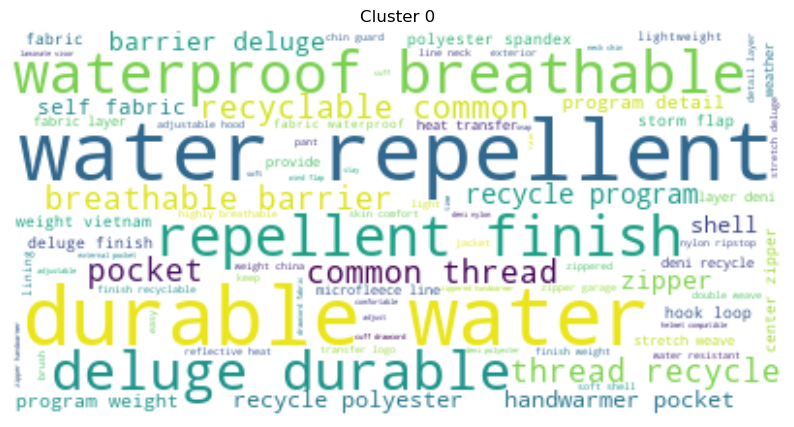

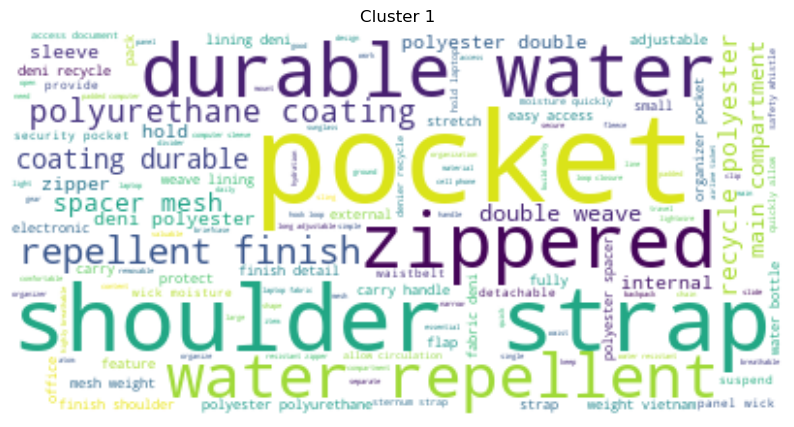

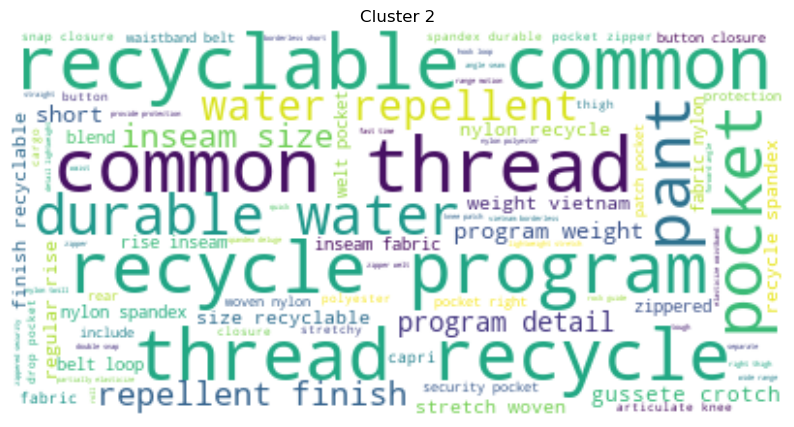

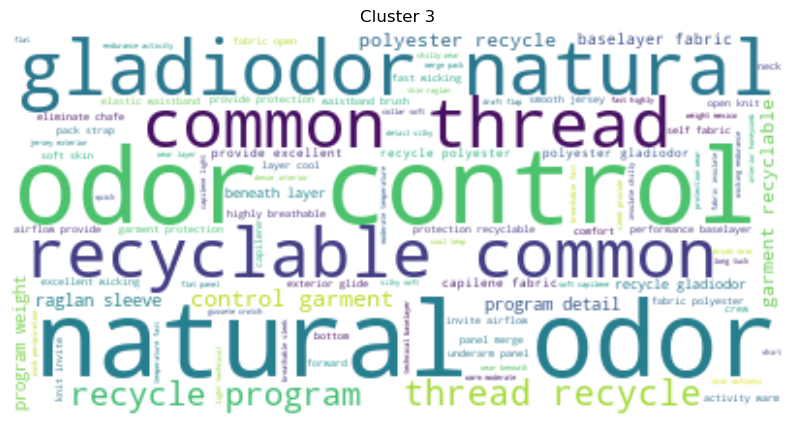

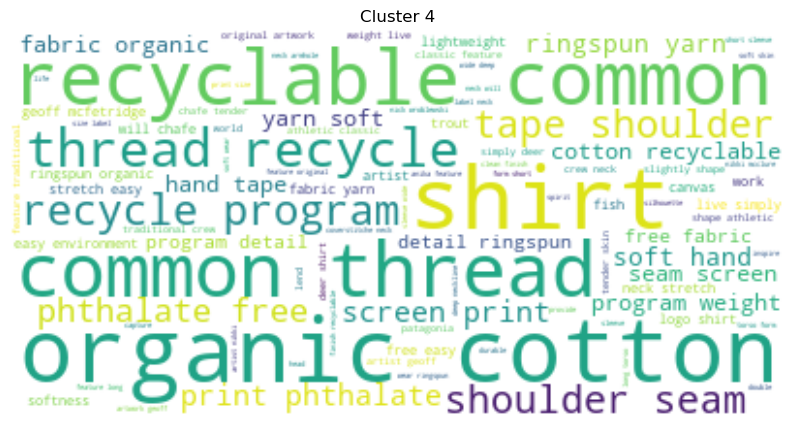

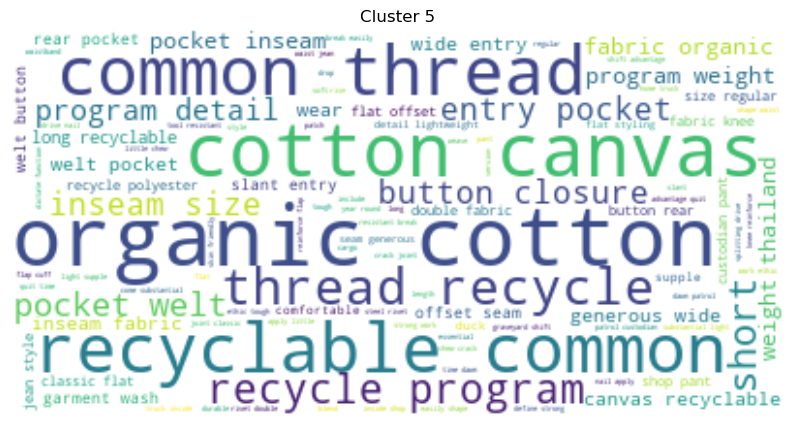

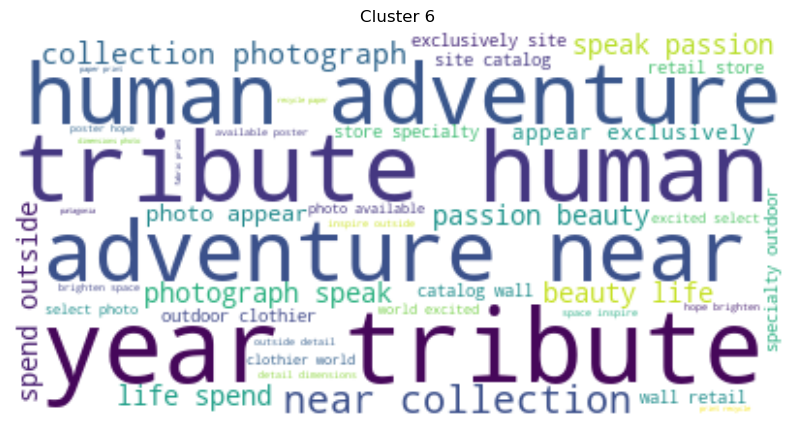

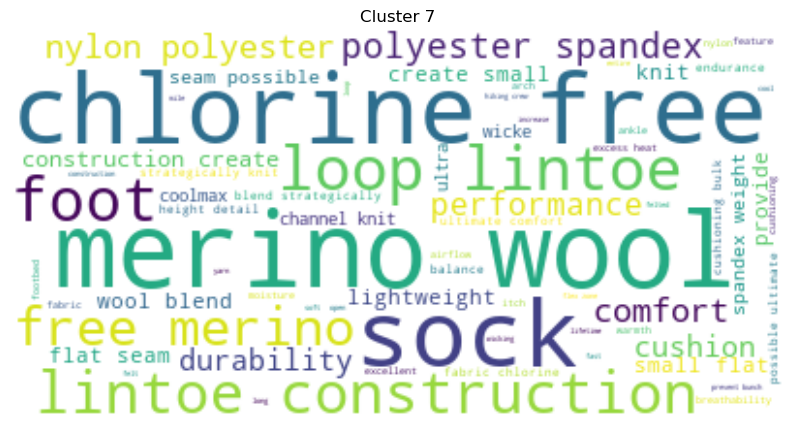

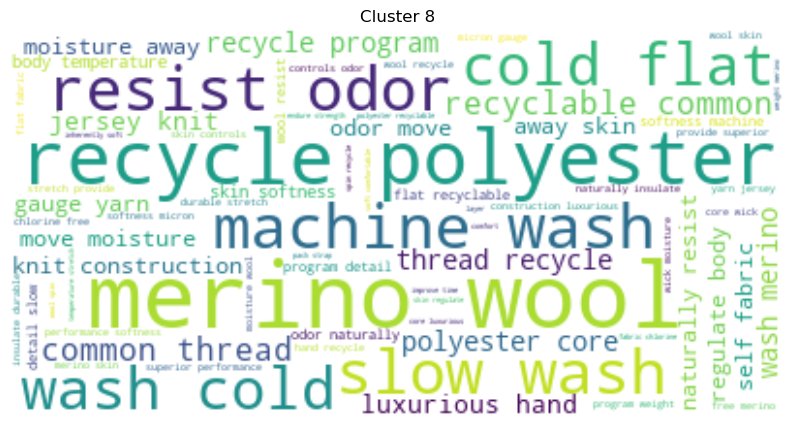

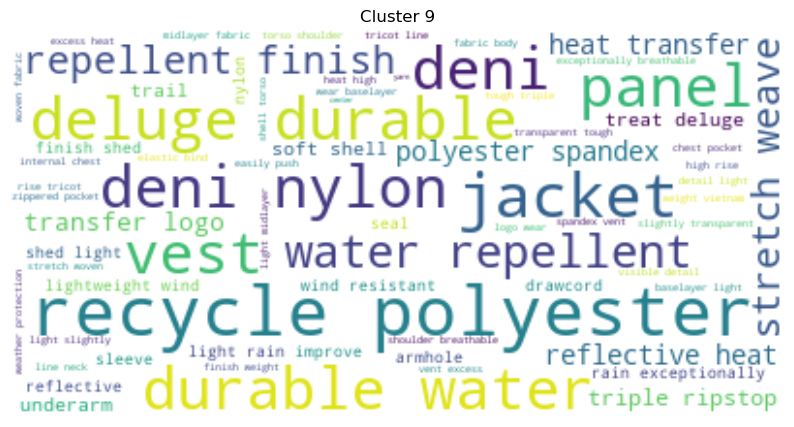

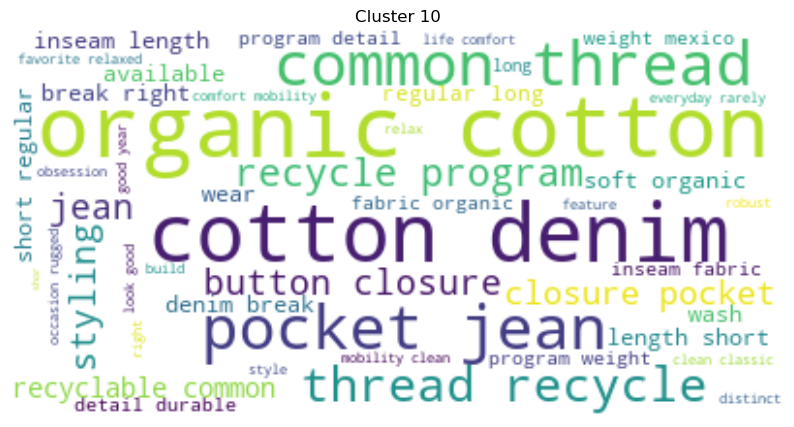

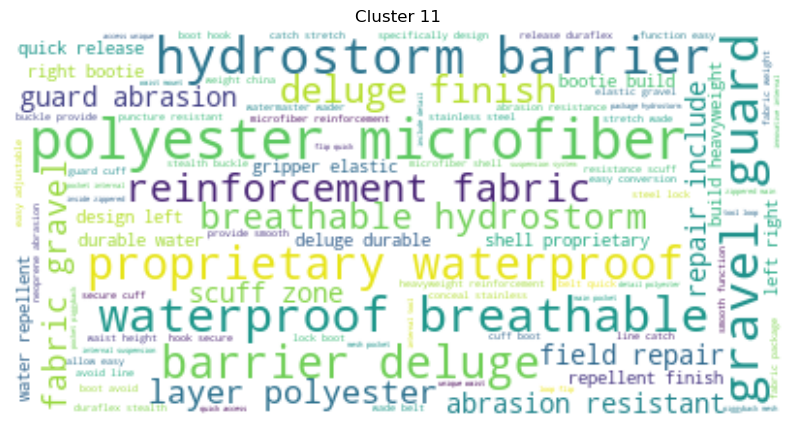

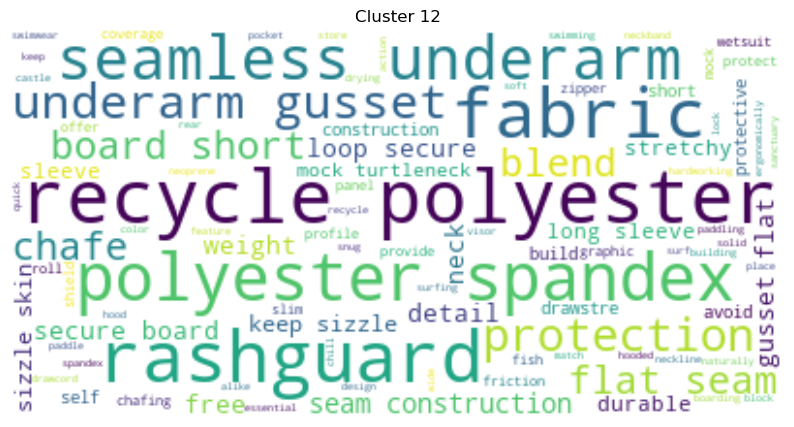

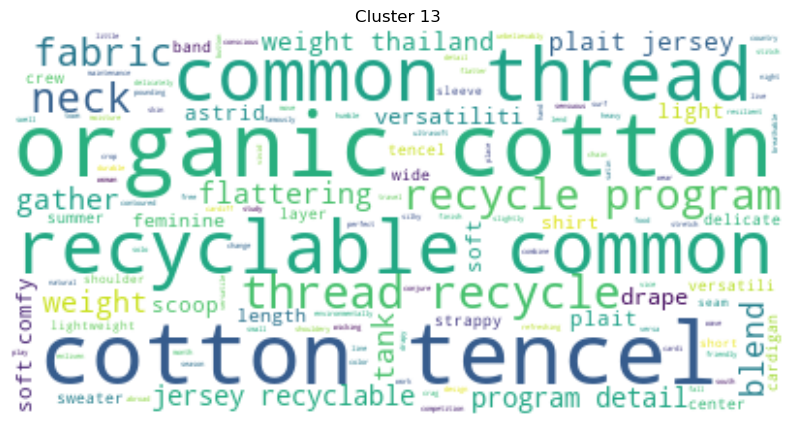

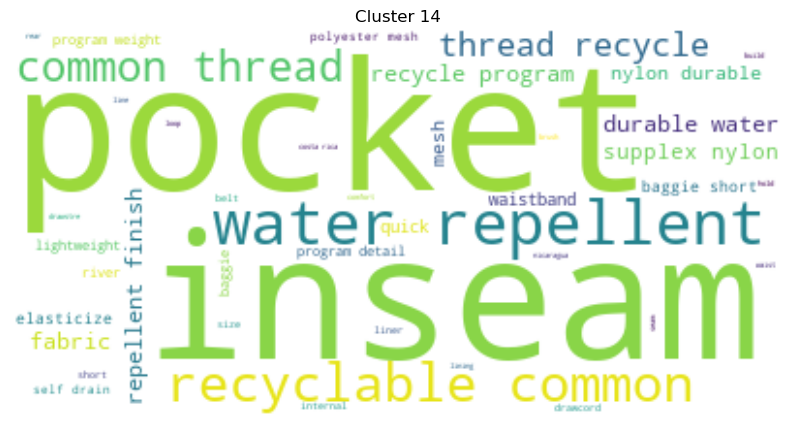

In [216]:
# Generate and display word clouds for each cluster
for cluster in set(clusters):
    if cluster == -1:
        continue  # Skip outliers
    cluster_texts = df[df['cluster'] == cluster]['clean_token'].values
    text = " ".join(cluster_texts)
    wordcloud = WordCloud(background_color='white').generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster}")
    plt.show()


# Save DF

In [217]:
df.head()

id                                        clean_token  cluster
0   1  active classic boxer reason boxer cult favorit...       -1
1   2  active sport boxer brief skin glory require mo...       -1
2   3  active sport brief superbreathable brief minim...       -1
3   4  alpine guide pant skin climb switch rock trave...        0
4   5  alpine wind high ridge steep alpine jacket ser...        0

In [218]:
#df.to_csv('/Users/antoinebertin/Documents/jedha/full_stack/projects_full_stack/north_face/df.csv', index=False)

# TruncatedSVD

In [219]:
# how many clusters i have identified
len(np.unique(clusters))

16

In [220]:
from sklearn.decomposition import TruncatedSVD

In [221]:
n_components = 15
lsa_model = TruncatedSVD(n_components=n_components, random_state=42)
# I create the document-topic matrix.
#Rows: documents | Columns: topics which is n_components
topic_encoded_df = lsa_model.fit_transform(X)

In [222]:
# Create a DataFrame for the encoded topics
topic_encoded_df = pd.DataFrame(topic_encoded_df, columns=["topic_" + str(i) for i in range(n_components)])

In [228]:
# Find the main topic for each document
main_topic = np.argmax(topic_encoded_df.values, axis=1)
topic_encoded_df['main_topic'] = main_topic

In [235]:
lsa_model.components_[0].argsort()[:-11:-1] #top 10 contributing features (words) for the first topic

array([2226, 2074, 1914,  631, 2225, 2082,  548, 2136, 2928, 1007])

In [231]:
# Extract and interpret topics + word clouds
feature_names = tfidf_vectorizer.get_feature_names_out()

In [232]:
feature_names

array(['abandon', 'ability', 'able', ..., 'zippers', 'zips', 'zone'],
      dtype=object)

Topic 0:
recycle pocket organic cotton recyclable polyester common program thread fabric


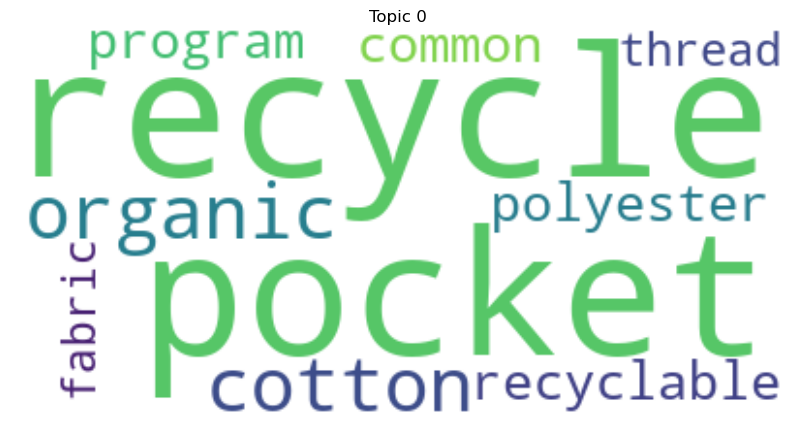

Topic 1:
organic cotton shirt ringspun print phthalate tape screen free yarn


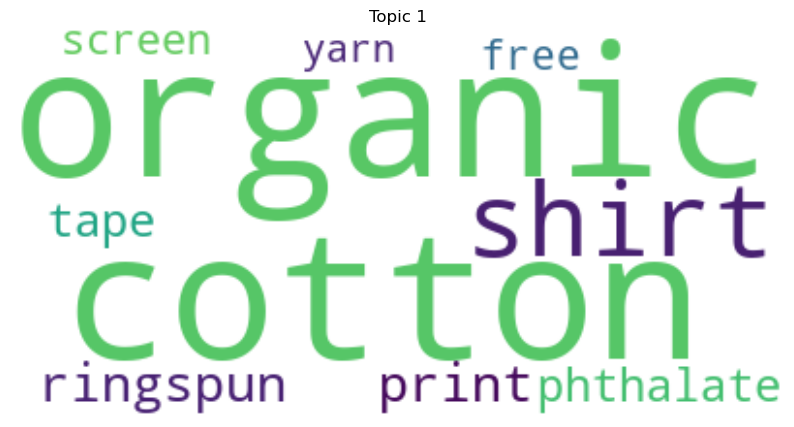

Topic 2:
merino odor wool control gladiodor capilene natural skin knit softness


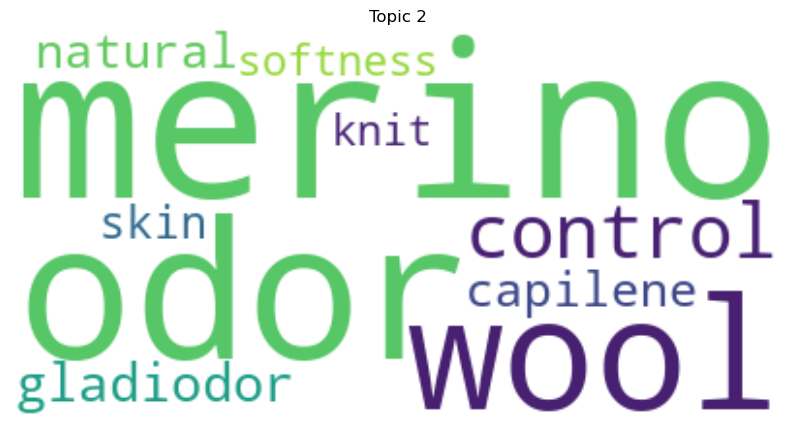

Topic 3:
inseam button organic short cotton canvas jean size welt closure


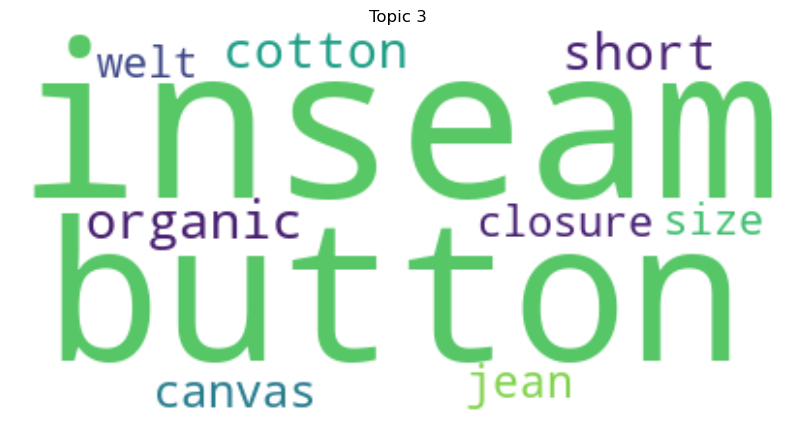

Topic 4:
merino wool wash slow machine naturally chlorine resist core cold


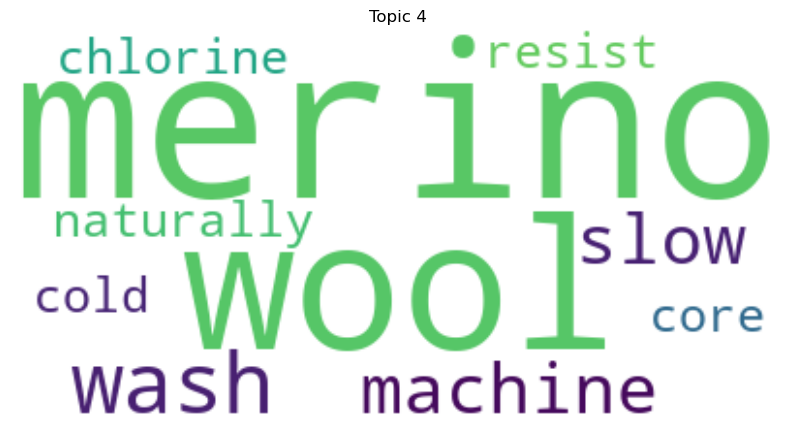

Topic 5:
nylon spandex coverage print rise blend free seamless chafe crotch


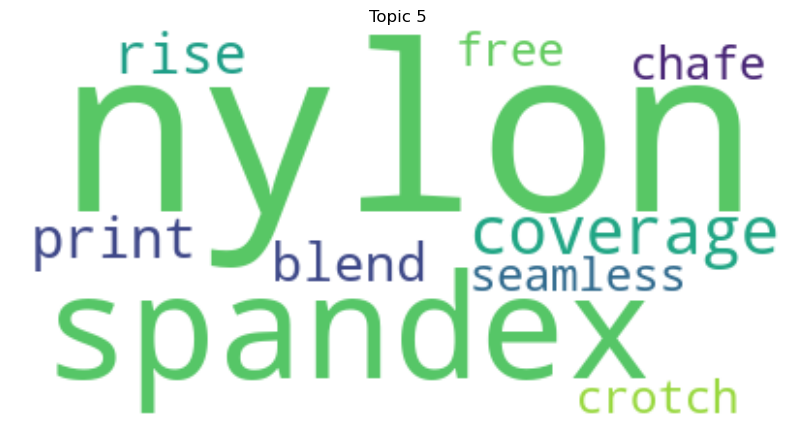

Topic 6:
pocket inseam polyurethane shoulder canvas mesh strap button compartment odor


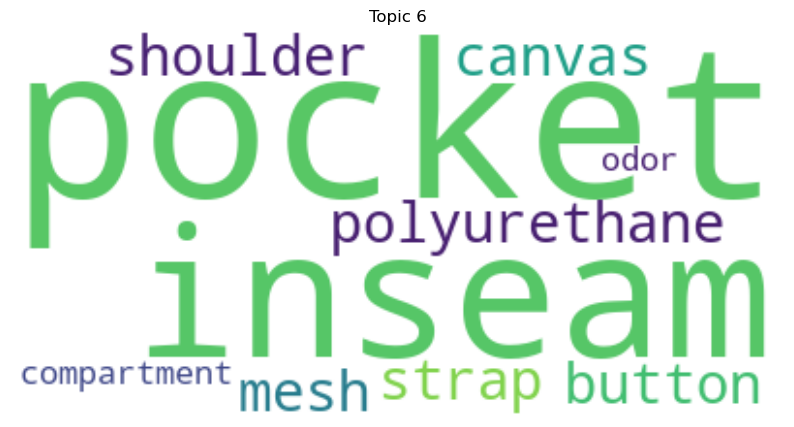

Topic 7:
strap mesh polyester fleece polyurethane deni compartment coating double hold


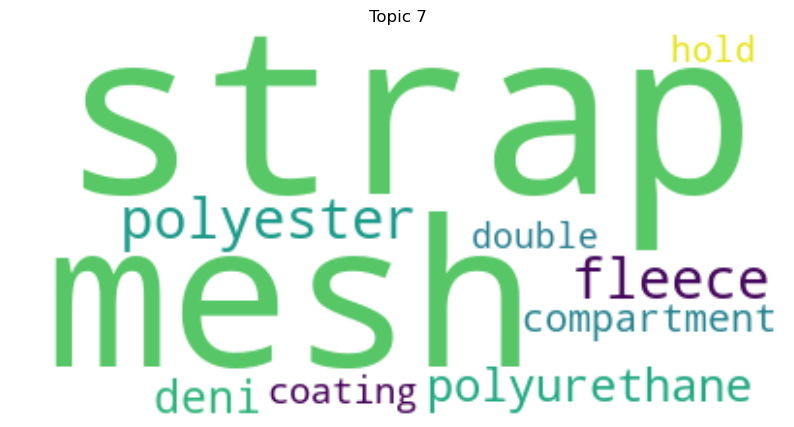

Topic 8:
waterproof barrier strap organic layer cotton mesh adjustable proprietary hydrostorm


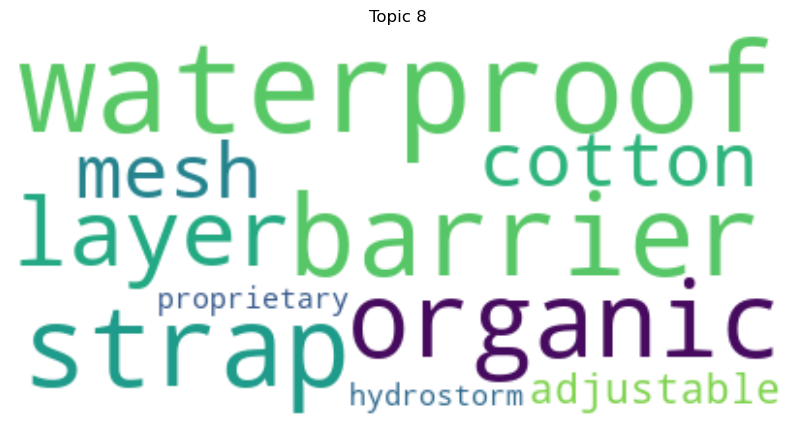

Topic 9:
photo poster outside print excited passion specialty hope outdoor clothier


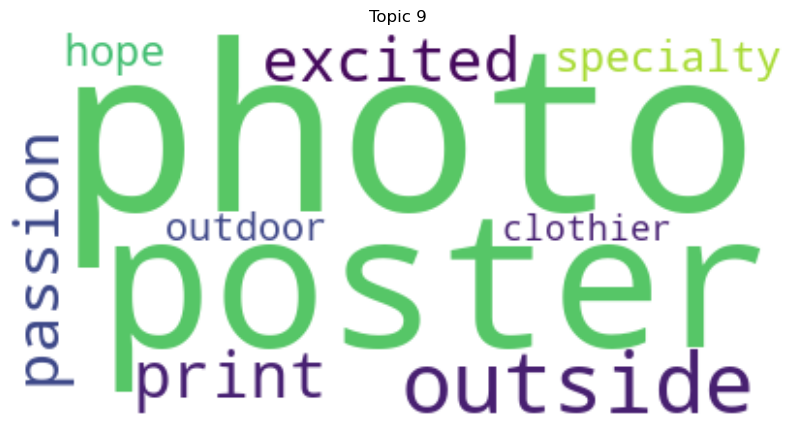

Topic 10:
reflective logo heat transfer protection runshade breathable ripstop deluge deni


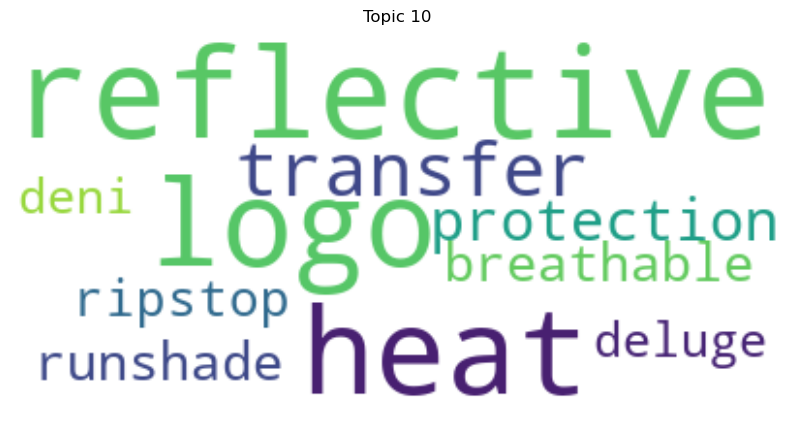

Topic 11:
polyester microfiber hydrostorm proprietary wader gravel rashguard heat zone reflective


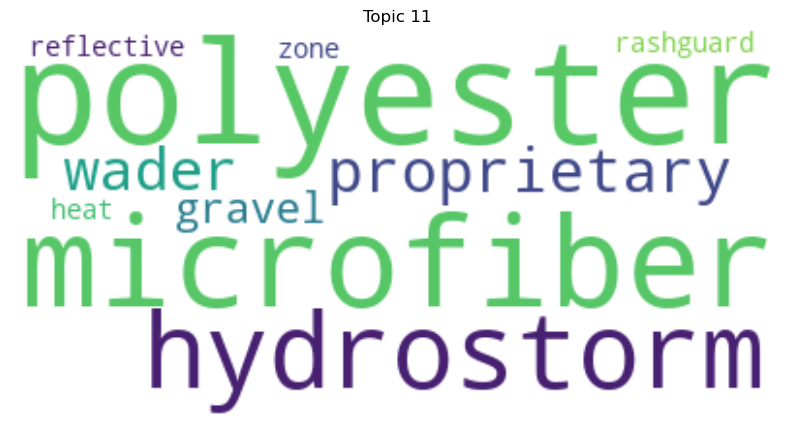

Topic 12:
fleece rashguard coverage hood protection pocket canvas waterproof short entry


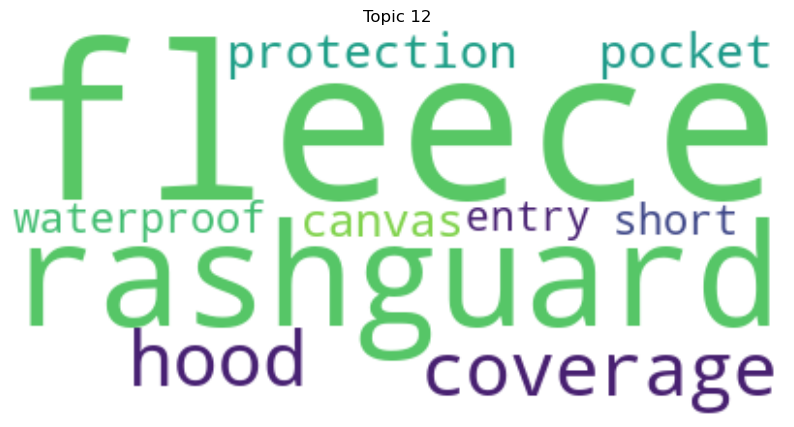

Topic 13:
protection snap collar shirt sleeve quick placket silky recycle vent


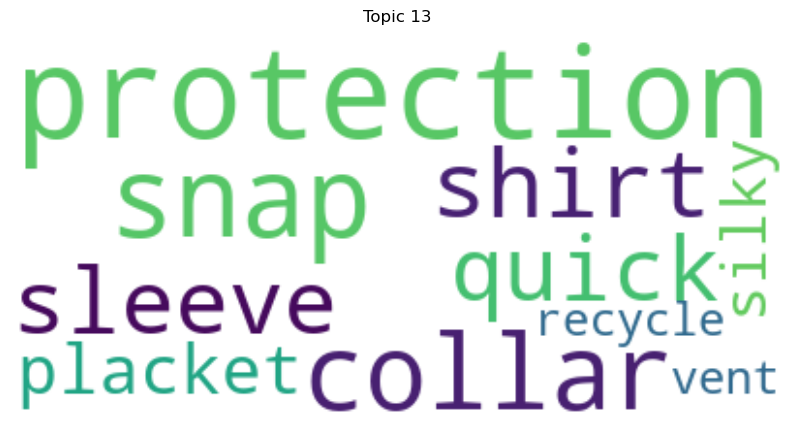

Topic 14:
construction loop sock knit tencel lintoe foot cargo comfort chlorine


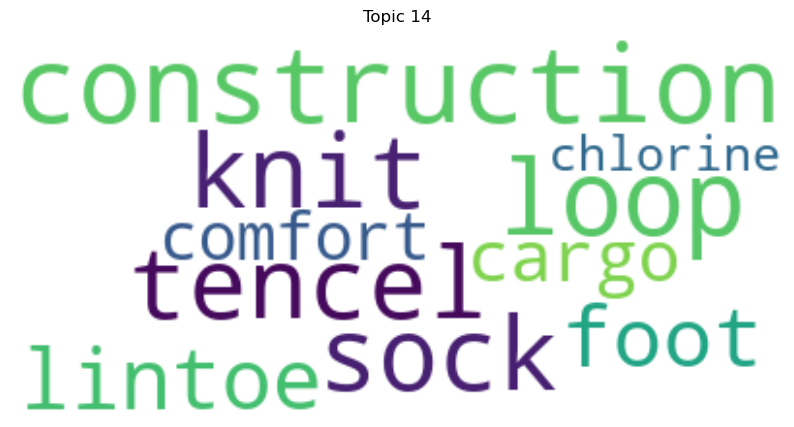

In [238]:
for topic_idx, topic in enumerate(lsa_model.components_):
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    print(f"Topic {topic_idx}:")
    print(" ".join(top_features))
    
    # Generate word clouds for each topic
    wordcloud = WordCloud(stopwords=None, background_color='white', max_words=100, max_font_size=120, random_state=42)
    word_freq = {word: weights[i] for i, word in enumerate(top_features)}
    wordcloud.generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_idx}')
    plt.show()


# testing ID similarity

In [247]:
item_id = 98

In [248]:
item_cluster = df.loc[df['id'] == item_id, 'cluster'].iloc[0]
item_cluster

4

In [253]:
# Find other items ID in the same cluster as item_cluster
similar_items = df[df['cluster'] == item_cluster]['id']
similar_items

25      26
35      36
40      41
55      56
57      58
62      63
63      64
64      65
67      68
70      71
71      72
72      73
94      95
97      98
101    102
115    116
123    124
137    138
138    139
143    144
150    151
151    152
166    167
168    169
169    170
176    177
177    178
184    185
236    237
238    239
275    276
287    288
288    289
314    315
321    322
332    333
333    334
334    335
335    336
346    347
365    366
371    372
372    373
396    397
422    423
431    432
432    433
446    447
447    448
466    467
469    470
470    471
475    476
488    489
490    491
492    493
Name: id, dtype: int64

In [254]:
# Exclude the item itself and pick up to 5 similar items
similar_items = similar_items[similar_items != item_id].head(5)
similar_items

25    26
35    36
40    41
55    56
57    58
Name: id, dtype: int64